
# Alpha Factor Evaluation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [4]:
DATA_STORE = '../data/stock_prices.h5'

In [5]:
factors = (pd.read_hdf(DATA_STORE, 'model_data')
           .dropna(axis=1, thresh=100000)
           .sort_index())

In [6]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1247456 entries, ('A', Timestamp('2007-01-04 00:00:00')) to ('ZMH', Timestamp('2015-06-25 00:00:00'))
Data columns (total 52 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   ret_01       1246956 non-null  float64
 1   ret_03       1245956 non-null  float64
 2   ret_05       1244956 non-null  float64
 3   ret_10       1242456 non-null  float64
 4   ret_21       1236956 non-null  float64
 5   ret_42       1226456 non-null  float64
 6   ret_63       1215956 non-null  float64
 7   ret_126      1184456 non-null  float64
 8   ret_252      1121456 non-null  float64
 9   ret_fwd      1247456 non-null  float64
 10  BB_UP        1237956 non-null  float64
 11  BB_LOW       1237956 non-null  float64
 12  BB_SQUEEZE   1237956 non-null  float64
 13  HT           1215956 non-null  float64
 14  SAR          1246956 non-null  float64
 15  ADX          1233956 non-null  float64
 16  ADXR         12274

In [7]:
fwd_returns = factors.filter(like='fwd').columns
features = factors.columns.difference(fwd_returns).tolist()

In [8]:
features

['AARONOSC',
 'AD',
 'ADOSC',
 'ADX',
 'ADXR',
 'ALPHA_21',
 'ALPHA_252',
 'ALPHA_63',
 'ATR',
 'BB_LOW',
 'BB_SQUEEZE',
 'BB_UP',
 'BOP',
 'CCI',
 'CMA_21',
 'CMA_252',
 'CMA_63',
 'HML_21',
 'HML_252',
 'HML_63',
 'HT',
 'MACD',
 'MACD_HIST',
 'MACD_SIGNAL',
 'MARKET_21',
 'MARKET_252',
 'MARKET_63',
 'MFI',
 'OBV',
 'PPO',
 'RMW_21',
 'RMW_252',
 'RMW_63',
 'RSI',
 'SAR',
 'SMB_21',
 'SMB_252',
 'SMB_63',
 'STOCH',
 'STOCHRSI',
 'ULTOSC',
 'WILLR',
 'ret_01',
 'ret_03',
 'ret_05',
 'ret_10',
 'ret_126',
 'ret_21',
 'ret_252',
 'ret_42',
 'ret_63']

## Factor Correlation

In [9]:
corr_common = factors.drop(fwd_returns, axis=1).corr(method='spearman')

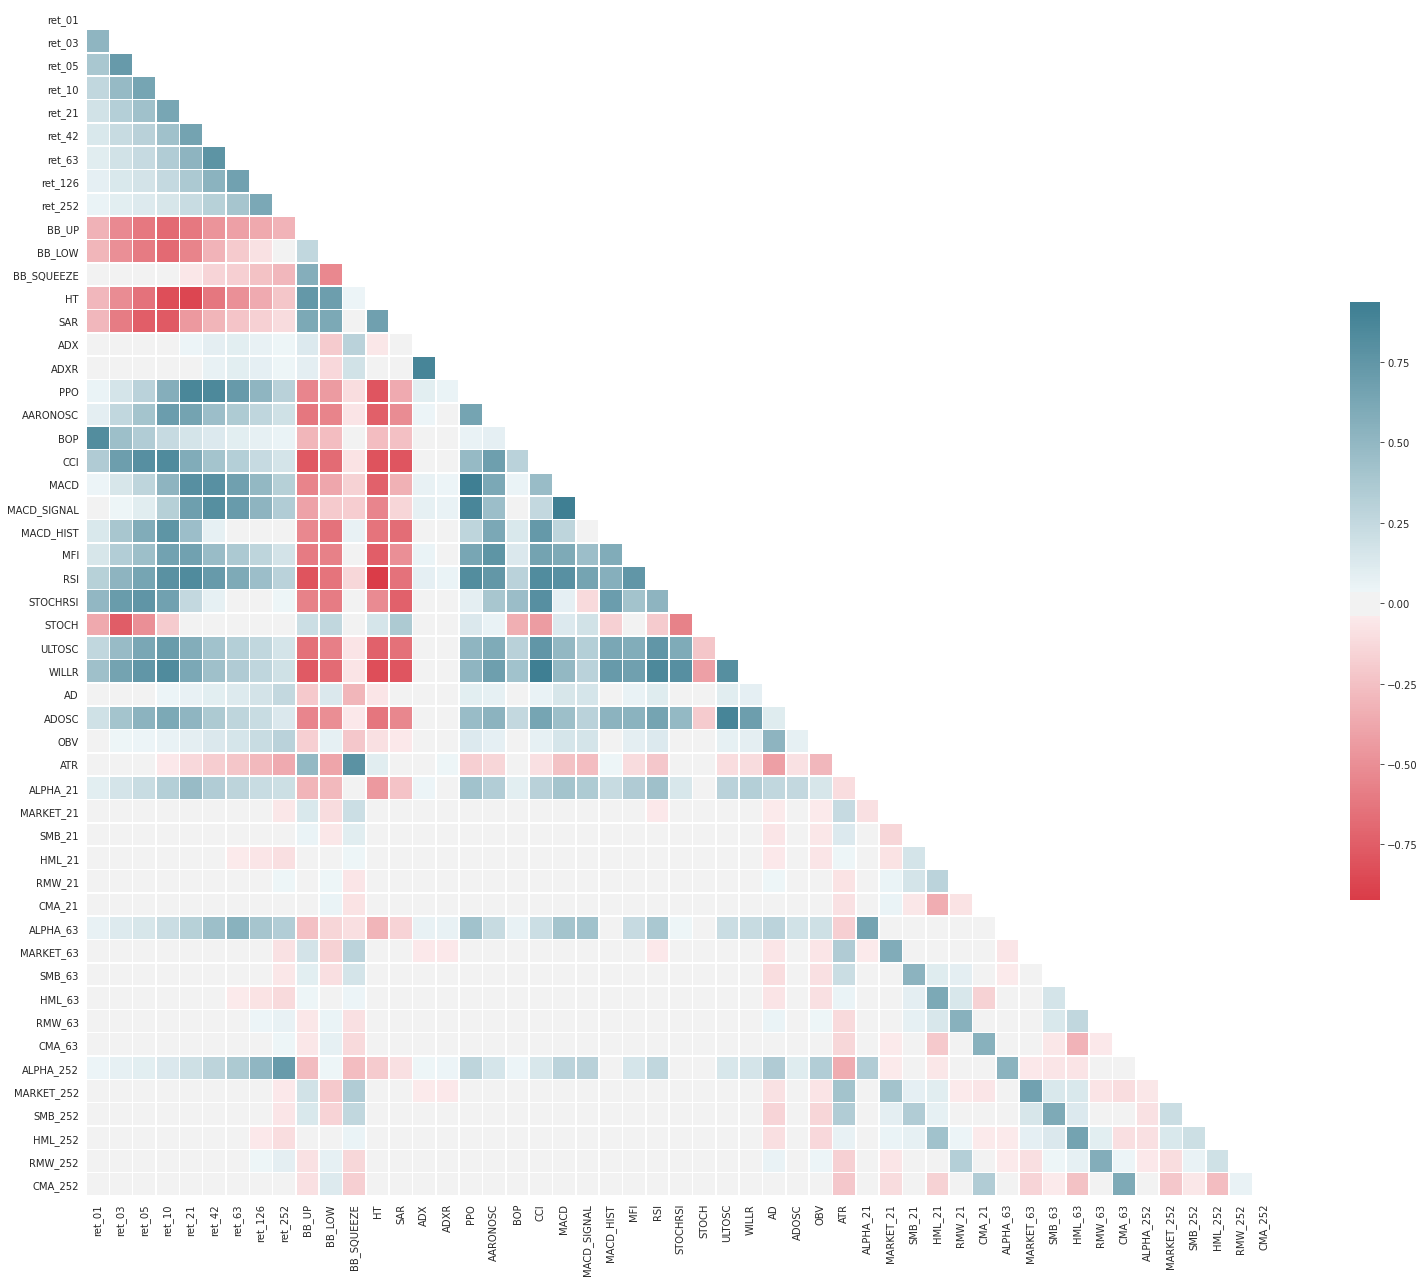

In [10]:
mask = np.triu(np.ones_like(corr_common, dtype=np.bool))
fig, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr_common, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout();

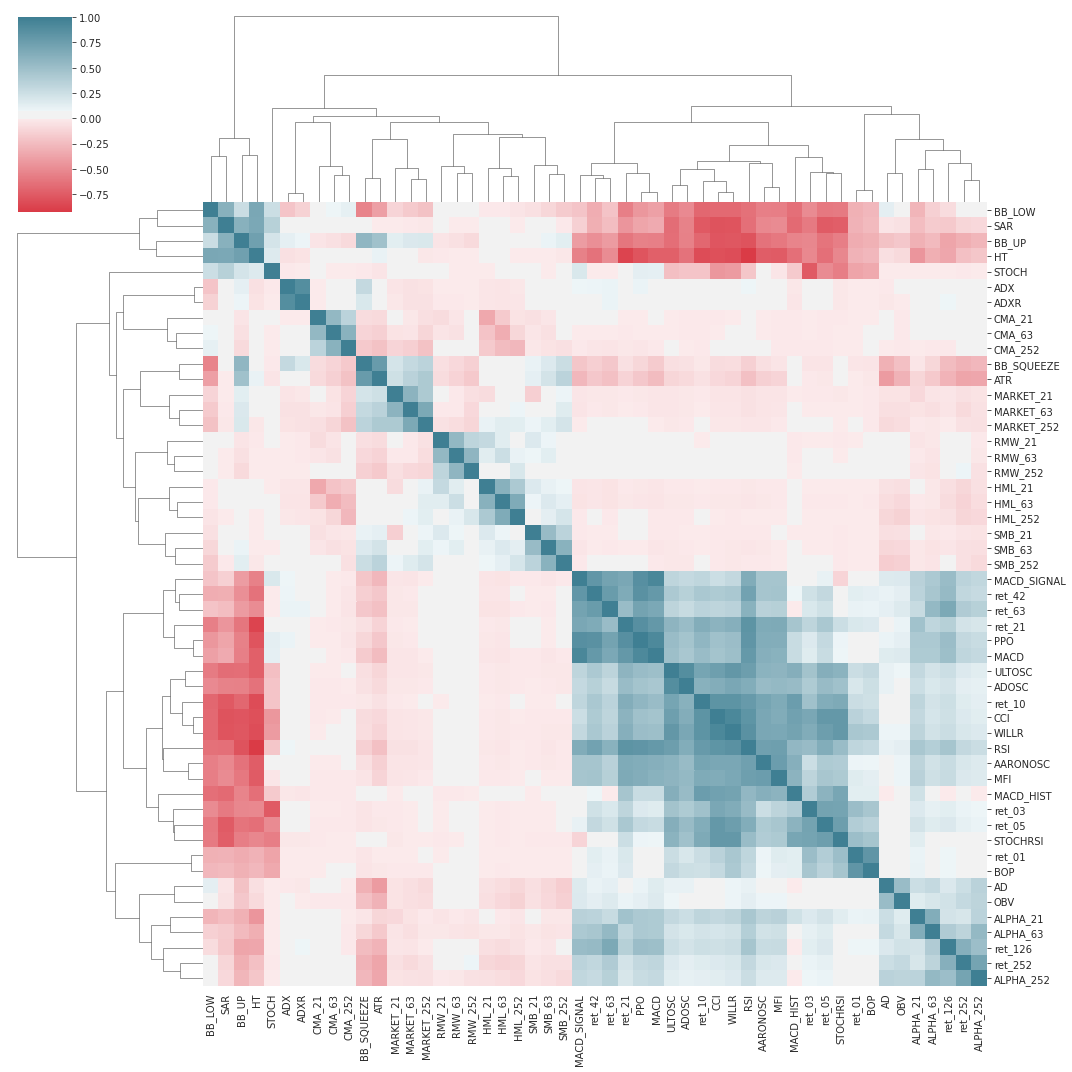

In [11]:
g = sns.clustermap(corr_common, cmap=cmap, figsize=(15, 15))

In [12]:
corr_ = corr_common.stack().reset_index()
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1!=corr_.x2].drop_duplicates('rho')

In [13]:
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
1041,MACD,MACD_SIGNAL,0.936011
997,CCI,WILLR,0.925405
836,PPO,MACD,0.924276
729,ADX,ADXR,0.885005
1407,ULTOSC,ADOSC,0.881676
636,HT,RSI,-0.923103
216,ret_21,HT,-0.866060
165,ret_10,HT,-0.828132
640,HT,WILLR,-0.825151
631,HT,CCI,-0.805833


## Forward return correlation

In [14]:
fwd_corr = factors.drop(['ret_fwd'], axis=1).corrwith(factors.ret_fwd, method='spearman')

In [15]:
fwd_corr = fwd_corr.dropna()
fwd_corr.to_csv('forward_correlation.csv')

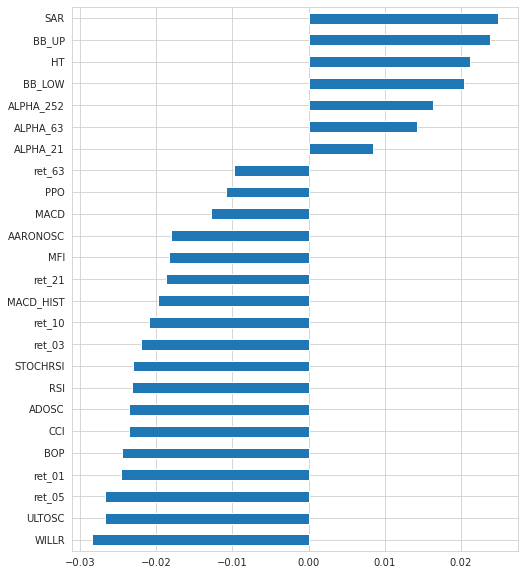

In [16]:
top50 = fwd_corr.abs().nlargest(25).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(8, 10),
                                            legend=False);

## Mutual Information

In [17]:
mi = {}
for feature in features:
    df = (factors
          .loc[:, ['ret_fwd', feature]]
          .dropna().sample(n=100000))
    discrete_features = df[feature].nunique() < 10
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.ret_fwd,
                                         discrete_features=discrete_features)[0]

In [18]:
mi = pd.Series(mi)
mi.to_csv('mutual_info.csv')

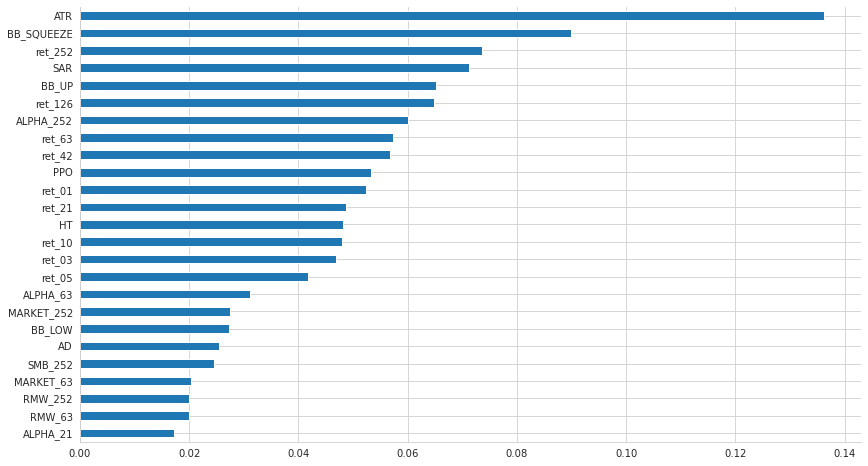

In [19]:
mi.nlargest(25).sort_values().plot.barh(figsize=(14,8))
sns.despine();

## LightGBM Feature Importance

In [20]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


In [21]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [22]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [23]:
factors['month'] = factors.index.get_level_values('date').month

In [24]:
categoricals = ['month']

In [25]:
features = factors.columns.difference(fwd_returns).tolist()

In [26]:
label = 'ret_fwd'

In [27]:
train_length = int(8.5 * 252)
test_length = 252
n_splits = 1

In [28]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              metric='None')
num_boost_round = 5000

In [29]:
lgb_data = lgb.Dataset(data=factors.loc[:, features],
                       label=factors.loc[:, label],
                       categorical_feature=categoricals,
                       free_raw_data=False)

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

feature_importance, ic, daily_ic = [], [], []

for i, (train_idx, test_idx) in enumerate(cv.split(X=factors)):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')
    fi = get_fi(model)
    fi.to_csv('feature_importance.csv')
    test_set = factors.iloc[test_idx, :]
    X_test = test_set.loc[:, model.feature_name()]
    y_test = test_set.loc[:, label]
    y_pred = model.predict(X_test)
    cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)
    cv_preds.to_hdf('preds.h5', f'preds/{i:02}')

    by_day = cv_preds.groupby(level='date')
    ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
    daily_ic_mean = ic_by_day.mean()
    daily_ic_median = ic_by_day.median()
    ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
    print(f'\n{time()-start:6.1f} | {ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.149749	valid's ic: 0.0373395
[200]	train's ic: 0.183215	valid's ic: 0.0397509
[300]	train's ic: 0.204418	valid's ic: 0.0421972
[400]	train's ic: 0.221485	valid's ic: 0.0409808
[500]	train's ic: 0.235292	valid's ic: 0.0400895
Early stopping, best iteration is:
[26]	train's ic: 0.105411	valid's ic: 0.0427956

 180.7 |  4.28% |  2.59% |  2.63%


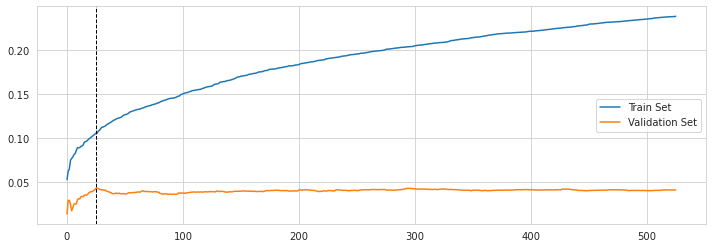

In [30]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1);

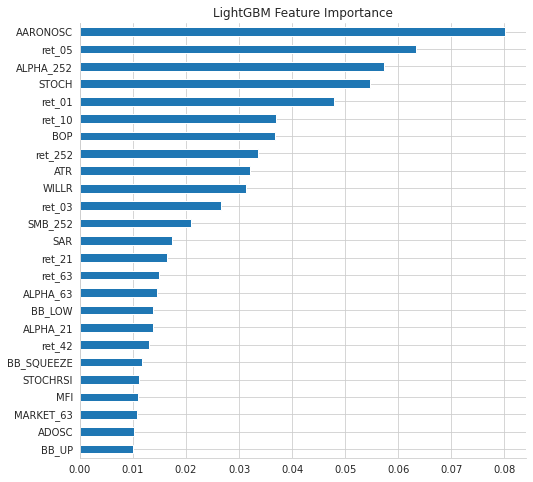

In [31]:
fi.drop('month').nlargest(25).sort_values().plot.barh(figsize=(8, 8), title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

In [32]:
shap.initjs()

In [33]:
model = lgb.Booster(model_file='lgb_model.txt')

In [34]:
explainer = shap.TreeExplainer(model)

In [35]:
# workaround for SHAP version 0.30: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [36]:
shap_values = explainer.shap_values(factors.iloc[train_idx, :].loc[:, model.feature_name()])

In [37]:
np.save('shap_values.npy', shap_values)

In [38]:
# shap_values = np.load('shap_values.npy')

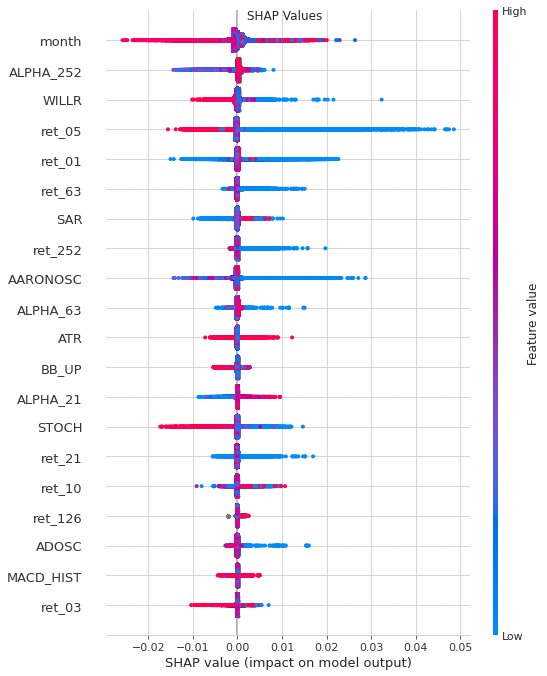

In [39]:
shap.summary_plot(shap_values,
                  factors
                  .iloc[train_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)
plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [40]:
shap_values = pd.DataFrame(shap_values, columns = features)

## Comparison

In [41]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0, squeeze=True)

In [42]:
shap_summary = shap_values.abs().mean()
shap_summary /= shap_summary.sum()

In [43]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.drop('month').to_frame('Feature Importance'))
         .join(shap_summary.drop('month').to_frame('SHAP Values')))

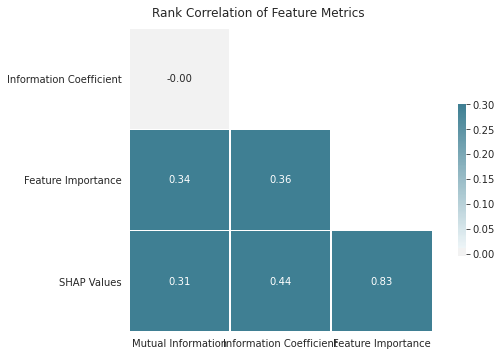

In [44]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}
corr = stats.assign(**cols).corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f')
plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=.92);

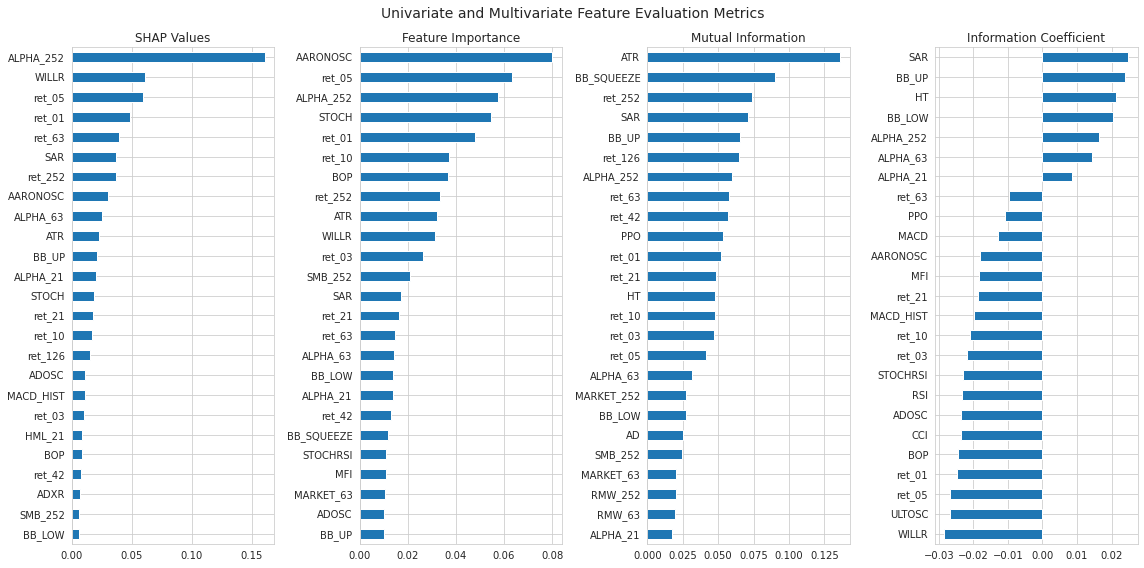

In [45]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.drop('month').nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.drop('month').nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

## Alphalens Analysis

In [46]:
tickers = factors.index.unique('ticker')

### Get trade prices

In [47]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [48]:
trade_prices = get_trade_prices(tickers)

In [49]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 11.5 MB


### Select factor

In [50]:
alpha = 'ATR'

In [51]:
factor = (factors[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

In [52]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1240442 entries, (Timestamp('2007-01-25 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1240442 non-null  float64
 1   5D               1240442 non-null  float64
 2   10D              1240442 non-null  float64
 3   factor           1240442 non-null  float64
 4   factor_quantile  1240442 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 52.1+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.001147,0.077324,0.017824,0.008502,248449,20.029070
2,0.011514,0.092727,0.023205,0.011106,247894,19.984328
3,0.013324,0.109163,0.027813,0.013826,247924,19.986747
4,0.015807,0.139493,0.033685,0.017198,247894,19.984328
5,0.019386,1.190772,0.049681,0.031591,248281,20.015527


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.024,-0.025,-0.026
beta,0.510,0.547,0.540
Mean Period Wise Return Top Quantile (bps),1.862,1.761,1.529
Mean Period Wise Return Bottom Quantile (bps),-1.714,-1.575,-1.478
Mean Period Wise Spread (bps),3.576,3.118,2.791


Information Analysis


,1D,5D,10D
IC Mean,-0.012,-0.006,-0.002
IC Std.,0.258,0.264,0.252
Risk-Adjusted IC,-0.047,-0.024,-0.009
t-stat(IC),-2.333,-1.217,-0.456
p-value(IC),0.020,0.224,0.649
IC Skew,-0.079,-0.076,-0.079
IC Kurtosis,-0.298,-0.435,-0.369


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.047,0.123,0.174
Quantile 2 Mean Turnover,0.108,0.275,0.381
Quantile 3 Mean Turnover,0.121,0.307,0.419
Quantile 4 Mean Turnover,0.099,0.258,0.359
Quantile 5 Mean Turnover,0.039,0.106,0.151


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.995,0.971,0.945


<Figure size 432x288 with 0 Axes>

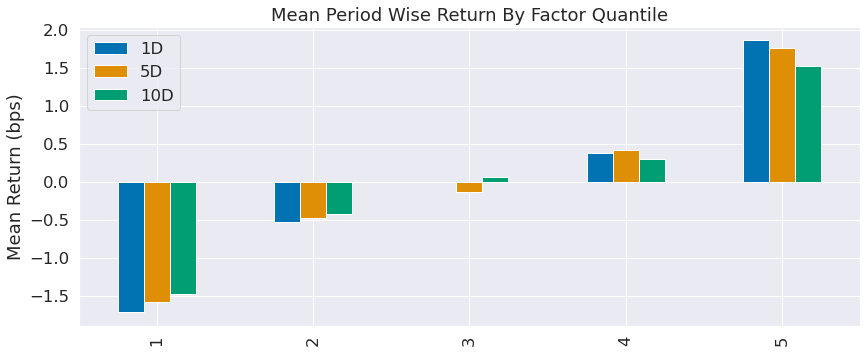

In [53]:
create_summary_tear_sheet(factor_data)